In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import numpy as np
from cfb_utils import get_data, run_test, get_lines, get_team_data
np.set_printoptions(precision=3, suppress=True)
import keras_tuner as kt
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import layers

In [2]:
cfb_features_train, cfb_features_test, cfb_labels_train, cfb_labels_test = get_data()

In [109]:
initializer = keras.initializers.RandomNormal(mean=0., stddev=1.)
model = keras.Sequential(
    [
        layers.Input(shape=(cfb_features_train.shape[1])),
        
        
        layers.Dense(512, activation="relu", bias_initializer=initializer),
        layers.Dense(256, activation="relu", bias_initializer=initializer),
        layers.Dense(128, activation="relu", bias_initializer=initializer),
        layers.Dropout(0.30),
        layers.Dense(64, activation="relu", bias_initializer=initializer),
        layers.Dense(32, activation="relu", bias_initializer=initializer),
        layers.Dense(16, activation="relu", bias_initializer=initializer),
        layers.Dense(8, activation="relu", bias_initializer=initializer),
        layers.Dropout(0.2),
        layers.Dense(4, activation="relu", bias_initializer=initializer),
        layers.Dense(2, activation="softplus", bias_initializer=initializer),
    ])
model.build()

In [111]:
model.compile(loss=keras.losses.MeanAbsoluteError(), 
              optimizer=keras.optimizers.Adam(learning_rate=0.001), 
              metrics = 'mse')
history = model.fit(cfb_features_train, cfb_labels_train, 
          validation_data=(cfb_features_test, cfb_labels_test), 
          epochs=10,
         )

Epoch 1/10
255/255 [==============================] - 4s 12ms/step - loss: 11.3080 - mse: 214.0764 - val_loss: 11.6084 - val_mse: 217.8332
Epoch 2/10
255/255 [==============================] - 3s 10ms/step - loss: 11.1268 - mse: 208.5337 - val_loss: 11.3346 - val_mse: 207.7408
Epoch 3/10
255/255 [==============================] - 3s 10ms/step - loss: 10.9629 - mse: 202.6437 - val_loss: 11.8055 - val_mse: 223.4067
Epoch 4/10
255/255 [==============================] - 3s 10ms/step - loss: 10.8412 - mse: 197.0575 - val_loss: 11.0196 - val_mse: 197.0785
Epoch 5/10
255/255 [==============================] - 3s 12ms/step - loss: 10.8629 - mse: 197.7728 - val_loss: 11.1943 - val_mse: 202.6993
Epoch 6/10
255/255 [==============================] - 3s 10ms/step - loss: 10.7032 - mse: 192.3125 - val_loss: 13.3117 - val_mse: 274.5964
Epoch 7/10
255/255 [==============================] - 3s 10ms/step - loss: 10.6582 - mse: 190.9744 - val_loss: 11.7907 - val_mse: 222.8785
Epoch 8/10
255/255 [=======

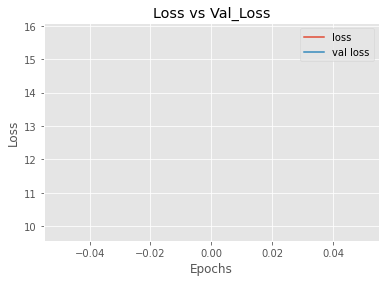

In [78]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.plot(history.history['loss'], label = 'loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.title("Loss vs Val_Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [44]:
run_test(cfb_features_test, cfb_labels_test, [model])

3070 / 4014
acc =  0.7648231190832088


In [58]:
cfb_features_train, cfb_features_test, cfb_labels_train, cfb_labels_test = get_data()
run_test(cfb_features_test, cfb_labels_test, model)

3014 / 4014
acc =  0.7508719481813653
INFO:tensorflow:Assets written to: models/acc_750/model/assets


In [3]:
lines = get_lines(2022,8)

In [114]:
test_on_spread(record, stats, elo, stats_list, lines, model)

Unable to test: Air Force vs. Colorado
Unable to test: Wyoming vs. Air Force
Unable to test: Air Force vs. Nevada
Unable to test: Air Force vs. Navy
Unable to test: Utah State vs. Air Force
Unable to test: UNLV vs. Air Force
0.7626666666666667
0.6213333333333333


In [96]:
predict_matchup(record, stats, elo, stats_list, model)

1: American Athletic
2: ACC
3: Big 12
4: Big Ten
5: Conference USA
6: FBS Independents
7: Mid-American
8: Mountain West
9: Pac-12
10: SEC
11: Sun Belt

Enter the number of the home team's conference: 4
Enter the number of the away team's conference: 4

0: Illinois
1: Indiana
2: Iowa
3: Maryland
4: Michigan
5: Michigan State
6: Minnesota
7: Nebraska
8: Northwestern
9: Ohio State
10: Penn State
11: Purdue
12: Rutgers
13: Wisconsin

Enter the home team's corresponding number: 4

0: Illinois
1: Indiana
2: Iowa
3: Maryland
4: Michigan
5: Michigan State
6: Minnesota
7: Nebraska
8: Northwestern
9: Ohio State
10: Penn State
11: Purdue
12: Rutgers
13: Wisconsin

Enter the home team's corresponding number: 9
Michigan: 18, Ohio State: 21


In [8]:
model = keras.models.load_model('models/acc_774/model')
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 512)               103936    
                                                                 
 dense_19 (Dense)            (None, 256)               131328    
                                                                 
 dense_20 (Dense)            (None, 128)               32896     
                                                                 
 dropout_4 (Dropout)         (None, 128)               0         
                                                                 
 dense_21 (Dense)            (None, 64)                8256      
                                                                 
 dense_22 (Dense)            (None, 32)                2080      
                                                                 
 dense_23 (Dense)            (None, 16)               

In [91]:
from sklearn.tree import DecisionTreeRegressor
rng = np.random.RandomState(1)
X = cfb_features_train
y = cfb_labels_train
# Fit regression model
regr = DecisionTreeRegressor(max_depth=9)
regr.fit(X, y)
# Predict
X_test = cfb_features_test
result = regr.predict(X_test)

In [92]:
test_on_spread(lines, [regr])

0.7573333333333333
0.6293333333333333


In [62]:
def test_on_spread(lines, model_list):
    correct = 0
    spread_correct = 0
    total = 0
    for line in lines:
        ht, at = line.home_team, line.away_team
        hp, ap = line.home_score, line.away_score
        inp = np.array([get_team_data(ht, at)])
        result = [model.predict(inp)[0] for model in model_list]
        php = 0
        for x in result:
            php+=x[0]
        pap = 0
        for x in result:
            pap+=x[1]
        php = php/len(result)
        pap = pap/len(result)
        if php>pap and hp>ap:
            correct+=1
        if php<pap and hp<ap:
            correct+=1
            
        provider = None
        if len(line.lines)==0:
            continue
        for x in line.lines:
            if x.provider == 'consensus':
                provider = x
        if provider == None:
            provider = line.lines[0]
            
        spread = provider.formatted_spread
        spread = spread.split(" ")
        num = abs(float(spread[len(spread)-1]))
        if len(spread)>2:
            favorite = spread[0]+" "+spread[1]
        else:
            favorite = spread[0]
        if favorite == ht:
            favorite = 'h'
        else:
            favorite = 'a'
        spread_correct+=check_spread(favorite, line.home_score, line.away_score, php, pap, num)
        total+=1
    print(correct/total)
    print(spread_correct/total)  
    
def check_spread(favorite, hp, ap, php, pap, spread):
    cs = hp-ap
    cas = False
    pcs = php-pap
    pcas = False
    if favorite == 'h':
        if cs<0:
            cas = False
        else:
            if cs>spread:
                cas = True
            else:
                cas = False
                
        if pcs<0:
            pas = False
        else:
            if pcs>spread:
                pcas = True
            else:
                pcas = False
    else:
        if cs>0:
            cas = False
        else:
            if abs(cs)>spread:
                cas = True
            else:
                cas = False
        
        if pcs>0:
            pas = False
        else:
            if abs(pcs)>spread:
                pcas = True
            else:
                pcas = False
    if cas==pcas:
        return 1
    else:
        return 0

In [65]:
test_on_spread(lines, [regr])

0.7546666666666667
0.632


In [33]:
from sklearn import linear_model
rng = np.random.RandomState(1)
X = cfb_features_train
y = cfb_labels_train
# Fit regression model
lassoReg = linear_model.Lasso(alpha=0.1)
lassoReg.fit(X,y)
# Predict
X_test = cfb_features_test
result = lassoReg.predict(X_test)

In [34]:
correct = 0
for i,x in enumerate(result):
    p_h = x[0]
    p_v = x[1]
    h = cfb_labels_test[i][0]
    v = cfb_labels_test[i][1]
    if h>v and p_h>p_v:
        correct+=1
    if h<v and p_h<p_v:
        correct+=1
correct/len(result)

0.7740408570004983

In [66]:
test_on_spread(lines, [lassoReg])

0.792
0.6853333333333333


In [46]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
X, y = cfb_features_train, cfb_labels_train
rfr = RandomForestRegressor(max_depth=6)
rfr.fit(X, y)
X_test = cfb_features_test
result = rfr.predict(X_test)

In [67]:
test_on_spread(lines, [rfr])

0.8106666666666666
0.624


In [70]:
from sklearn.linear_model import Ridge
rng = np.random.RandomState(0)
clf = Ridge(alpha=1.0)
clf.fit(X, y)
test_on_spread(lines, [clf])

0.7866666666666666
0.6826666666666666


In [68]:
test_on_spread(lines, [clf])

0.7866666666666666
0.6826666666666666


In [93]:
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
regr1 = ElasticNet(random_state=0)
regr1.fit(X, y)
test_on_spread(lines, [regr1])

0.784
0.6933333333333334


In [106]:
from sklearn import linear_model
reg = linear_model.Lars(n_nonzero_coefs=40, normalize=False)
reg.fit(X,y)
test_on_spread(lines, [reg])

0.7786666666666666
0.6986666666666667


In [124]:
reg1 = linear_model.LassoLars(alpha=.7, normalize=False)
reg1.fit(X,y)
test_on_spread(lines, [reg1])

0.784
0.6853333333333333


In [140]:
# model_list = [regr, lassoReg, rfr, clf, regr1, reg, reg1]
model_list = [clf, regr1, reg, reg1]

test_on_spread(lines, model_list)

0.7946666666666666
0.7013333333333334


In [145]:
for x in model_list:
    print(type(x))

<class 'sklearn.linear_model._ridge.Ridge'>
<class 'sklearn.linear_model._coordinate_descent.ElasticNet'>
<class 'sklearn.linear_model._least_angle.Lars'>
<class 'sklearn.linear_model._least_angle.LassoLars'>


In [148]:
import pickle
pkl_filename = "lassolars_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(reg1, file)
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)
test_on_spread(lines, [pickle_model])

0.784
0.6853333333333333
